In [15]:
# Query images in Aletheia

import time
import numpy as np
import pandas as pd
import random
from timezonefinder import TimezoneFinderL
import pytz
from pysolar.solar import *
from geopy import distance
from datetime import datetime as dt

from brtdevkit.core.db import DBConnector, DatetimeFilter
from warnings import filterwarnings
filterwarnings("ignore")

tf = TimezoneFinderL()

def get_solar_angle(timestamp, latitude, longitude):
    """
    Requires datetime, TimezonefinderL, pytz and pysolar libraries
    
    Inputs: Timestamp, latitude, longitude.
    Outputs: Solar angle between (-90 , 90). Daylight conditions will always be > 0.
    """
    # Localize and adjust UTC timestamps to local timezone
    utc = pytz.utc.localize(timestamp)
    tz = tf.timezone_at(lat=latitude, lng=longitude)
    adjusted_timestamp = utc.astimezone(tz)

    # If there are invalid GPS coordinates, the function will return 'NaN'
    if adjusted_timestamp.tzinfo is not None:
        return get_altitude(latitude, longitude, adjusted_timestamp)
    else:
        return float('NaN')

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Helper function to create DataFrame of relevant Shasta data.
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

def get_specific_fields(df, artifact = 'nrg'):
    """
    Takes a dataframe with specific [grower, farm, operating_field_name] combinations and retreives document records from 
    Aletheia matching just those fields. Useful when you  need a collection of fields but don't want to query the entire record.
    :param: df: a pandas dataframe with [grower, farm, operating_field_name] columns.
    :param: artifact: The type of artifact you want to return. Default is 'nrg'
     """
    db = DBConnector()
    filters = {'grower': df['grower'][0], 'farm': df['farm'][0],'operating_field_name': df['operating_field_name'][0]}
    img_filters = {'project_name': 'shasta', **filters, 'artifacts.kind':artifact}
    master_df = db.get_documents_df('image', img_filters, limit=None)
    for n in range(len(df[1:])):
        filters = {'grower': str(df['grower'][n]), 'farm': str(df['farm'][n]),'operating_field_name': str(df['operating_field_name'][n])}
        img_filters = {'project_name': 'shasta', **filters, 'artifacts.kind':artifact}
        field_df = db.get_documents_df('image', img_filters, limit=None)
        if len(field_df)==0:
            print(f'Could not find field: { df.operating_field_name[n]} from grower: {df.grower[n]}')
        master_df = pd.concat([master_df, field_df], axis=0)
    print(f'Query returned {len(master_df)} {artifact} records.')
    return master_df

# Set start date for query
start = dt(2021, 3, 29)
end = dt(2021, 4, 17)

# DCMs
dcms_2020 = ['DCM-MANATEE', 'DCM-WALRUS', 'DCM-SEAL', 'DCM-OTTER', 'DCM-PORPOISE', 'DCM-DOLPHIN']
dcms_2021 = ['DCM11', 'DCM12', 'DCM13', 'DCM14', 'DCM16', 'DCM17','DCM18','DCM19', 'DCM20', 'DCM21','DCM23', 'DCM24','DCM25', 'DCM26', 'DCM27', 'DCM28']
#machines = ["SHASTA-FB-BRADLEY","SHASTA-FB-PALADIN", "BLACKBIRD", 'ATM-DUCKDUCK', 'ATM-GOOSE']
crops = ['COTTON', 'CORN', 'SOYBEANS']

updcms = ['DCM13', 'DCM14', 'DCM28', 'DCM21', 'DCM18', 'DCM23', 'DCM16', 'DCM19']

# Select all annotated images past the start date
filters = {'artifacts.kind':'nrg', 'robot_name':{'$in': dcms_2021}
          }

full_df, elapsed_time = get_shasta_data(filters=filters, start=start, end=end)
full_df['grower_farm_field'] = full_df['grower'] + '_' + full_df['farm'] +'_' + full_df['operating_field_name']
print(f"Queried {len(full_df)} images in {elapsed_time:.2f} s.")

Queried 132438 images in 90.75 s.


In [13]:
needs_hr = pd.read_csv('04_16_21_shasta_labels.csv')
needs_hr['grower'] = None
needs_hr['farm'] = None
needs_hr['operating_field_name'] = None

for n in range(len(needs_hr)):
    needs_hr['grower'][n] = needs_hr['grower_farm_field'][n].split('_')[0]
    needs_hr['farm'][n] = needs_hr['grower_farm_field'][n].split('_')[1]
    needs_hr['operating_field_name'][n] = needs_hr['grower_farm_field'][n].split('_')[2]

gffs = needs_hr.drop_duplicates('grower_farm_field', keep='first')
print(len(gffs))
print(len(gffs.grower_farm_field.unique()))
print(gffs.iloc[25])

df = get_specific_fields(gffs)
#df['grower_farm_field'] = df['grower'] + '_' + df['farm'] +'_' + df['operating_field_name']
df.grower_farm_field.value_counts()

27
27
_id                                              607944a5077a09a023c71ee0
grower_farm_field       Brandon Brenton_King Ranch_Northwest field fro...
crop_name                                                          COTTON
experiment_id                                                        Run2
grower                                                    Brandon Brenton
farm                                                           King Ranch
operating_field_name                             Northwest field from Gin
Name: 1501, dtype: object


KeyboardInterrupt: 

In [16]:
needs_hr = pd.read_csv('04_16_21_shasta_labels.csv')
needs_hr.head()

,_id,grower_farm_field,crop_name,experiment_id
0,60790d012cc99d8a3661ef9b,Condrey_Ashly_A66,CORN,Run6
1,6079dc85077a09a023c78797,Brandon Benton_King Ranch_Northern field of Gin,COTTON,Run8
2,60798093552b3f233e71b3e1,Brandon Benton_King Ranch_Southern field of Gin,COTTON,Run2
3,6079d5e04aeb3cb9d9d41bc4,Skala_Glenn's_pens east,CORN,Run3
4,6078d9443b6e56ea2905c20b,Stutts_Davison_Dion Field,CORN,Run7


In [4]:
full_df['solar_angle'] = full_df.apply(lambda x: get_solar_angle(x['collected_on'], x['latitude'], x['longitude']), axis=1)

In [8]:
full_df[full_df['solar_angle']<=5].grower_farm_field.value_counts()

eddie davis_davis farms_2107 harris                  1207
carson stewart_greenway test farm_furrow north       1177
carson stewart_greenway test farm_northwest pivot    1175
matt coley_cbc farms_front of gussies                1085
wessel_minor_akin dryland                             952
john haug_John home_southwest                         895
john haug_home_across creek                           845
s&d farms_w marshall_w marshall                       672
neil lee_ronnie lee farms_zuber 4                      20
Name: grower_farm_field, dtype: int64

In [4]:
full_df = full_df[['_id','grower', 'farm', 'operating_field_name', 'grower_farm_field','group_id', 'crop_name', 'experiment_id','latitude', 'longitude', 'collected_on', 'has_human_annotation', 'camera_height']]

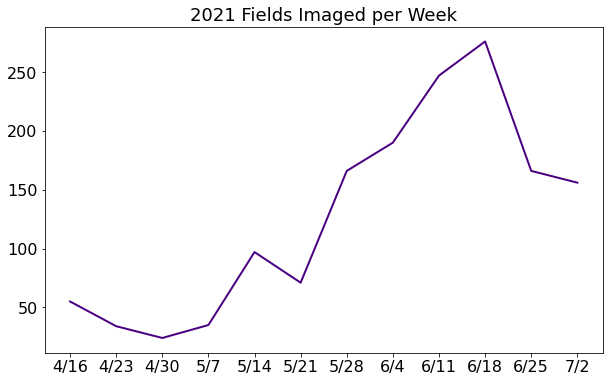

In [3]:
from matplotlib import pyplot as plt
fields = [55, 34, 24, 35, 97, 71, 166, 190, 247, 276, 166, 156]

dates = ['4/16', '4/23', '4/30', '5/7', '5/14', '5/21', '5/28', '6/4', '6/11', '6/18', '6/25', '7/2']

plt.figure(figsize=(10,6))
plt.title('2021 Fields Imaged per Week', fontsize=18)
plt.plot(dates, fields, linewidth=2, color ='indigo')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('2021_field_counts.png', dpi=100)
plt.show()

In [16]:
groups = low.groupby(['grower', 'operating_field_name', 'grower_farm_field']).size().reset_index()

maxs = []
mins = []

for g in groups.grower_farm_field.unique():
    maxs.append(max(low[low['grower_farm_field']==g].solar_angle))
    mins.append(min(low[low['grower_farm_field']==g].solar_angle))
    
minmax = pd.DataFrame({'min_solar_angle':mins, 'max_solar_angle':maxs})
groups = pd.concat([groups,minmax], axis=1)
groups

,grower,operating_field_name,grower_farm_field,0,min_solar_angle,max_solar_angle
0,Bubba Leita,Creek Field,Bubba Leita_J&P Leita Farms_Creek Field,1355,9.465356,14.718047
1,CG Davis,shop 40,CG Davis_Sons 2 Farm_shop 40,502,5.000105,6.488273
2,Chris Davlin,"28.9250744, -96.4763700","Chris Davlin_Bullseye_28.9250744, -96.4763700",895,12.209857,14.896736
3,Condrey,C7,Condrey_Clearfield_C7,1020,11.001362,14.645195
4,Dusten Oehme s,4th st,Dusten Oehme s_Oehme s Farm_4th st,287,10.596195,13.914848
5,Earl Kline,K 13,Earl Kline_no name_K 13,969,11.210070,14.874628
6,Joey Burcham,F1 -2,Joey Burcham_Burcham_F1 -2,592,13.530226,14.998752
7,Stuart Briggerman,19,Stuart Briggerman_Briggerman West_19,812,9.321825,11.246112
8,Stuart Briggman,8,Stuart Briggman_Briggman west_8,382,5.000836,5.761958
9,Wrights,North Center,Wrights_TAMU Greenville_North Center,726,12.690466,14.963270


### Functions to Remove Overlap and Order for Breadth-First Labeling


In [3]:
import random
from geopy import distance

def remove_overlap(df, filter_df=None):
    """
    Given a DataFrame of DCM image metadata, select images that do not overlap with each other.
    TODO: Enable fiter_df, a separate df of already submitted/lebeled image_ids to avoid choosing duplicate ids.
    
    Inputs:
    DataFrame with Latitude, Longitude, camera_height
    (optional) filter_df - a pandas Series of image_ids that have already been submitted, to factor into the caluculations.
    
    Returns:
    DataFrame containing only images selected to have 0% image-to-image overlap. 
    """
    cdf = df.sort_values(['grower_farm_field','collected_on'])

    # Calculate area covered by each image
    def calc_distance(z):
        """
        Calculate the linear distance covered from the top to the bottom of an image.
        """
        # DCM-specific camera variables for angle and vertical Field of View (FOV)
        fov_v = np.radians(45.7)
        theta = np.radians(28)
        xmin = z * np.tan(theta - (fov_v / 2.0))
        xmax = z * np.tan(theta + (fov_v / 2.0))
        image_length  = xmax - xmin
        return image_length

    # calculate image_length, clipping any impossibly large image_lengths to a max of 3.5m
    cdf['image_length'] = np.clip(calc_distance(cdf.camera_height), 0, 3.5)

    # Initialize counting variables
    last_chosen = 0
    chosen = []
    
    if filter_df is not None:
        if len(cdf[cdf._id.isin(filter_df._id)]) == 0:
               print('There are no already submitted images in this list.')
        else:
            filter_out = cdf[cdf['_id'].isin(filter_df._id)]
            print(f'There are {len(cdf[cdf._id.isin(filter_df._id)])} already submitted images in this list.')
            cdf= cdf[~cdf._id.isin(filter_out._id)]
            filter_out['has_human_annotation'] = True
            print(filter_out.has_human_annotation.value_counts())
            cdf = pd.concat([cdf, filter_out], axis=0)
            cdf = cdf.sort_values(['grower_farm_field','collected_on'])
        # ids in cdf that are in filter_df should have has_human_annotation set to True
        #for n in range(len(cdf)):
            #if cdf._id[n] in set(filter_df._id):
                #cdf.has_human_annotation[n] = True

    # Choose images for annotation based on the amount of overlap with neighboring images
    for n in range(len(cdf)):
        # Calculate distance from the previous image chosen for annotation
        dist = distance.distance([cdf.latitude[n], cdf.longitude[n]], [cdf.latitude[last_chosen],cdf.longitude[last_chosen]]).meters
        # If the distance is greater than the previous image length, the image is chosen for annotation
        # If the image has already been labeled, pass over it for selection and mark it as the last_chosen
        if cdf['has_human_annotation'][n] == True:
            # Might be able to speed this up using a stack instead of a list
            chosen.append(False)
            last_chosen= n
        elif (dist >= cdf['image_length'][last_chosen]):
            chosen.append(True)
            last_chosen = n
        # If the distance is not sufficient, the image is not chosen
        else:
            chosen.append(False)
            
    ch = pd.DataFrame({'chosen':chosen}, index = cdf.index)
    selected = pd.concat([cdf, ch], axis=1)
    print(f'{((len(selected[selected.chosen==True])/len(selected))*100):.2f}% or {len(selected[selected.chosen==True])} of the images remain after removing overlap.')
    return selected[selected['chosen']==True]

def create_image_list(df, field_limit=120, formatted = False):
    """
    Given a DataFrame, create a list of images that are ordered for maximum diversity.
    
    Inputs:
    df - A DataFrame with relevant fields included.
    field_limit - The number of images to select per field. Default is 100 (or 120 - tbd)
    
    Returns:
    Dataframe of images chosen for labeling, ordered to be breadth-first. 
    (optional) - If formatted == True the function returns a nicely formatted df to export as a csv.
    """
    # Setting the seed parameter makes the same random pattern every time
    # To obtain a different shuffle change or omit the seed parameter
    random.seed(42)
    # Sort by grower, farm and operating_field_name to find unique fields
    sorted_ai = df.sort_values(['grower_farm_field','collected_on'])
    # Create empty column Dataframe to concatenate fields onto post-indexing
    master = pd.Series(sorted_ai.columns)

    # Iterate through fields to create indices, shuffle them within each field and then assign to the selection_index column
    for o in sorted_ai.grower_farm_field.unique():
        field = sorted_ai[sorted_ai.grower_farm_field == o]
        # Create indices of appropriate length
        indices = list(range(len(field)))
        # Shuffle indices
        random.shuffle(indices)
        # Merge selection_index with rest of dataframe and concatenate onto master dataframe
        ind = pd.Series(indices, index = field.index, name = 'selection_index')
        mn = pd.concat([field, ind], axis = 1)
        master = pd.concat([master, mn], axis =0)
    #print(field_limit)
    # Sort by selection_index
    master.sort_values('selection_index', inplace=True)
    master = master[master['selection_index']<field_limit]
    if formatted:
        return master[['grower_farm_field', '_id']]
    else:
        return master


In [10]:

from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow,Flow
from google.auth.transport.requests import Request
import os
import pickle

SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

# here enter the id of your google sheet
SAMPLE_SPREADSHEET_ID_input = '15n7Q7Pike2tZPt3tCtFzltmsmHYHRa4A4zOp_dtb51o'
SAMPLE_RANGE_NAME = 'A1:E1000'

def main():
    global values_input, service
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'client_secret_548494862685-dsak7p6lj4ovilgl08fjlhknkb7f8umb.apps.googleusercontent.com.json', SCOPES) # here enter the name of your downloaded JSON file
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result_input = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID_input,
                                range=SAMPLE_RANGE_NAME).execute()
    values_input = result_input.get('values', [])

    if not values_input and not values_expansion:
        print('No data found.')

main()

sheet_df=pd.DataFrame(values_input, columns=['grower', 'farm', 'operating_field_name', 'crop_name', 'date_collected'])
sheet_df['grower_farm_field'] = sheet_df['grower'] +'_' + sheet_df['farm'] + '_' + sheet_df['operating_field_name']
sheet_df.drop(0,inplace=True)
sheet_df.head()

,grower,farm,operating_field_name,crop_name,date_collected,grower_farm_field
1,CA skiles,Barton,2,Corn,3/29,CA skiles_Barton_2
2,brt test,college station parking,parking lot,Test,3/29,brt test_college station parking_parking lot
3,Skiles Farm,Barton,B16,Corn,3/30,Skiles Farm_Barton_B16
4,Skiles,Barton,6,Corn,3/30,Skiles_Barton_6
5,Skiles,Barton,6,Duplicate,3/30,Skiles_Barton_6


In [15]:
new_fields = full_df[~full_df.grower_farm_field.isin(sheet_df.grower_farm_field)]
new_fields.grower_farm_field.value_counts().to_csv('new_fields.csv')

In [10]:
new_fields = pd.read_csv('valid_fields.csv')
#lab_sheet = lab_sheet.fillna(False)
fields_normal = new_fields.grower_farm_field.unique()
print(len(fields_normal))

189


In [7]:
print(len(lab_sheet))
lab_sheet = lab_sheet[(lab_sheet['do_not_label']==False) & (lab_sheet['label_complete']==False) & (lab_sheet['needs_attention']==False) & (lab_sheet['low_light']==False)]
len(lab_sheet)

898


386

In [102]:
main_list = create_image_list(no_o[no_o.grower_farm_field == dirk], field_limit = 120)
print(len(main_list))
for gff in lab_sheet.grower_farm_field.unique():
    field = lab_sheet[lab_sheet['grower_farm_field']==gff].reset_index()
    #print(int(field['n_labels'][0]))
    try:
        if (field['additional'].any()==True) and (field['n_labels'].any() < 240):
            pr = create_image_list(no_o[no_o['grower_farm_field']==gff], field_limit = (240 - int(field['n_labels'][0])))
            main_list = pd.concat([main_list, pr], axis=0)
        elif (field['additional'].any()==False) and (lab_sheet[lab_sheet['grower_farm_field']==gff]['n_labels'].any() < 120):
            pr = create_image_list(no_o[no_o['grower_farm_field']==gff], field_limit = (120 - int(field['n_labels'][0])))
            main_list = pd.concat([main_list, pr], axis=0)
        else:
            continue
    except:
        #continue
        print(gff)
        
len(main_list)

120
Skiles Farm_Barton_B16
Skiles_Barton_6
Hoelscher_Anderson_Anderson triangle
Hoelscher_elmer_bedrick
Skala_Glenn's_pens east
Hoelscher_Warrens_Big Field
Hutka_elmer_zach's house
Hutka_Gonzales_Red Barn
Zach Hutka_PJ's_PJ
Brandon Andel_Andel home_Home ranch
Willberg_Radle_Front
Willberg_South Side of the Road_South of Waterway
Willberg_South side of the road_North of Waterway
Brandon Andel_330&3086_330&3086 west
David Codell_Skiles_02 37.00
jason evans_evans and sons_emily newell
joe jacobs_jacobs farm_599
scott fullen_mid south family_9
scott fullen_mid south family_11


22879

In [123]:
len(main_list)

22759

In [4]:
# Compile list of images already sent out for labeling
import os

print(os.getcwd())
if os.getcwd() != '/home/williamroberts/code/brtdevkit/Projects/Utilities/Image selection/2021_image_lists':
    os.chdir('/home/williamroberts/code/brtdevkit/Projects/Utilities/Image selection/2021_image_lists')
image_lists = os.listdir(os.getcwd())
    
master_list = pd.read_csv(image_lists[0])
print(len(master_list))
print(len(image_lists))

for csv in image_lists[1:]:
    if csv.endswith('.csv'):
        next_list = pd.read_csv(csv)
        master_list = pd.concat([master_list, next_list], axis=0)
        print(len(master_list))

os.chdir('/home/williamroberts/code/brtdevkit/Projects/Utilities/Image selection')
print(f'There have been {len(master_list)} images submitted to date.')

/home/williamroberts/code/brtdevkit/Projects/Utilities/Image selection
250
16
5246
5465
9591
35322
57991
64788
79854
82852
85585
89893
98170
120307
124732
126892
There have been 126892 images submitted to date.


In [55]:
# Download the evaluations sheet to be able to select just the new fields

if os.getcwd() != '/home/williamroberts/code/brtdevkit/Projects/Utilities/Image selection':
    os.chdir('/home/williamroberts/code/brtdevkit/Projects/Utilities/Image selection')
    
evaluated = pd.read_csv('evaluations.csv')
evaluated['grower_farm_field'] = evaluated['grower'] +'_' + evaluated['farm'] + '_' + evaluated['operating_field_name']
print(evaluated.columns)

evaluated = evaluated[~evaluated['grower_farm_field'].isin(master_list.grower_farm_field.unique())]

additional = evaluated[(evaluated['need_additional']==True) & (evaluated['Crop_name']!='Fallow')]
normal = evaluated[(evaluated['need_additional']==False) & (evaluated['Crop_name']!='Fallow')]

#fields = evaluated[~evaluated['grower_farm_field'].isin(master_list.grower_farm_field.unique())]['grower_farm_field'].to_list()
list(additional.grower_farm_field)

Index(['grower', 'farm', 'operating_field_name', 'Crop_name',
       'need_additional', 'grower_farm_field'],
      dtype='object')


['carson stewart_greenway test farm_southwest pivot',
 'haigwood_D&M Farms_larimore',
 'carson stewart_greenway test farm_northwest pivot',
 'Wrights_TAMU Greenville_South hill',
 'Wrights_TAMU Greenville_North Center',
 'David Codell_Skiles_02 37.00',
 'David Codell_Skiles_02 29.40',
 'Brandon Benton_King Ranch_482 (SW)',
 'Chris Davlin_Bullseye_28.9250744, -96.4763700',
 'Chris Hajovsky_CLH Farms_Hlavinka',
 'Chris Davlin_Bullseye_28.894, -96.393',
 'Bubba Leita_J&P Leita Farms_Creek Field']

In [6]:
#remove overlap from full_df
#full_df = full_df[full_df['solar_angle']>5]
print(len(df))
no_o = remove_overlap(df, filter_df = master_list)
len(no_o)

59616
There are 5035 already submitted images in this list.
True    5035
Name: has_human_annotation, dtype: int64
23.74% or 14152 of the images remain after removing overlap.


14152

In [17]:
# Clear the full_df from memory
master_list =None
full_df = None

In [7]:
main_list = create_image_list(no_o, field_limit = 120)
len(main_list)

5975

In [19]:
fl = first_list.grower_farm_field.value_counts().reset_index()
fl.columns = ['grower_farm_field', 'image_count']
good_fields = fl[fl['image_count']>100].grower_farm_field.unique()
first_list = first_list[first_list.grower_farm_field.isin(good_fields)]
print(len(first_list.grower_farm_field.unique()))

242


In [34]:
# create image list for fields_add
add = no_o[no_o['grower_farm_field'].isin(fields_add)]
print(len(fields_add))
second_list = create_image_list(add, field_limit=240)
print(len(second_list))
second_list.grower_farm_field.value_counts()

7
960


hunter planting_cameta_highlinepole          240
cg davis_sons 2 farm_school                  240
Allen Below_Section 20_9&10                  240
austin allred_allred farms_pegues south 1    240
Name: grower_farm_field, dtype: int64

In [35]:
final_list = pd.concat([first_list, second_list], axis=0)

all_in = fields_normal + fields_add

print(len(all_in) == len(final_list.grower_farm_field.unique()))
print(len(final_list))

final_list.grower_farm_field.value_counts()

False
4126


hunter planting_cameta_highlinepole                  240
austin allred_allred farms_pegues south 1            240
cg davis_sons 2 farm_school                          240
Allen Below_Section 20_9&10                          240
kent Heiman_home_gallgar place                       120
john haug_bern_bern southwey                         120
kent Heiman_RETHMANS_RETHMANS                        120
caldwell_coleman_mw 41                               120
stutts bros farms_2626_lsu                           120
shawn becker_becker_80- lower                        120
quiton stolls_stolls_1                               120
allena allred_allred farms_pegues nw                 120
CG Davis_Sons 2 Farm_shop 40                         120
caldwell_garnett_farmstead                           120
allen allred_allred farms_hwy 80                     120
stutts bros farms_2626_gus field                     120
caldwell_coleman_coleman south                       120
dunn farms_runnymede_RM-1      

In [17]:
# Confirm there are all three image types available for the selected images
from datetime import datetime as dt
#chosen  = full_df[full_df._id.isin(final_list._id)]
chosen = full_df[full_df['_id'].isin(needs_hr['_id'])]
print(len(chosen))

# group_ids from final list
gids = chosen.group_id.unique()
print(len(gids))

# Set start date for query
start = dt(2021, 3 , 29)
end = dt(2021, 4, 17)


# Select all annotated images past the start date
nrg_filters = {'artifacts.kind':'nrg', 'robot_name':{'$in': dcms_2021}}
hr_filters = {'artifacts.kind':'high_res_corrected', 'robot_name':{'$in': dcms_2021}}
hra_filters = {'artifacts.kind':'high_res_aligned', 'robot_name':{'$in': dcms_2021}}

#nrg_df, elapsed_time = get_shasta_data(filters = nrg_filters, start=start, end=end)
#nrg_df = nrg_df[nrg_df['group_id'].isin(gids)]
#print(len(nrg_df))
hr_df, elapsed_time = get_shasta_data(filters = hr_filters, start=start, end=end)
hr_df = hr_df[hr_df['group_id'].isin(gids)]
print(len(hr_df))
hra_df, elapsed_time = get_shasta_data(filters = hra_filters, start=start, end=end)
hra_df = hra_df[hra_df['group_id'].isin(gids)]
print(len(hra_df))


2998
2998
2998
0


In [ ]:
##### USE THIS VERSION FOR SPECIFIC FIELDS ONLY #####

chosen = full_dfdf[full_df['_id'].isin(needs_hr['_id'])]
print(len(chosen))

# group_ids from final list
gids = chosen.group_id.unique()
print(len(gids))

#nrg_df = get_specific_fields(needs_hr, artifact = 'nrg')
#nrg_df = nrg_df[nrg_df['group_id'].isin(gids)]
rgb_df = get_specific_fields(needs_hr, artifact = 'rgb')
rgb_df = rgb_df[rgb_df['group_id'].isin(gids)]
hra_df = get_specific_fields(needs_hr, artifact = 'high_res_aligned')
hra_df = hra_df[hra_df.group_id.isin(gids)]
hrc_df = get_specific_fields(needs_hr, artifact = 'high_res_corrected')
hrc_df = hrc_df[hrc_df.group_id.isin(gids)]

In [21]:
#final_list = main_list[main_list['crop_name'].isin(['CORN', 'COTTON', 'SOYBEANS'])]
#print(len(final_list))
corrected_final = chosen[chosen['group_id'].isin(list(hr_df.group_id.unique()))][['_id','grower_farm_field','crop_name', 'experiment_id', 'selection_index']]

if len(corrected_final) == len(hr_df):
    print(f'All NRG images also have a high res image. The final list is {len(corrected_final)} images long.')
else:
    print(f'There are {abs(len(corrected_final)-len(hr_df))} images missing.')
    
corrected_final = corrected_final.set_index('_id')
print(len(corrected_final))
corrected_final.head()

All NRG images also have a high res image. The final list is 2998 images long.
2998


,grower_farm_field,crop_name,experiment_id
_id,,,
6079a14e077a09a023c76733,Brandon Benton_King Ranch_Southern field of Gin,COTTON,Run2
607971cb6c257545df18ce4f,Brandon Benton_King Ranch_Southern field of Gin,COTTON,Run2
607985c75d646f3a640a5a8f,Brandon Benton_King Ranch_Southern field of Gin,COTTON,Run2
607978c652197cdf82c9d9d4,Brandon Benton_King Ranch_Southern field of Gin,COTTON,Run2
60798093552b3f233e71b3e1,Brandon Benton_King Ranch_Southern field of Gin,COTTON,Run2


In [33]:
# Create new columns with the high_res_corrected for each image and high_res_aligned for each image where available.

yall = nrg_df.merge(hra_df, on='group_id', how='left')
yarft = nrg_df.merge(hr_df, on='group_id', how='left')
print(len(yarft))
print(len(yall.group_id.unique()))
len(yall)

6360
5975


6360

In [34]:
yarft = yarft[['_id_x', '_id_y', 'crop_name_x', 'experiment_id_x']]#
yarft.columns = ['_id', 'hrc_id', 'crop_name', 'experiment_id_x']
yall=yall[['_id_x', '_id_y']]
yall.columns = ['_id', 'hra_id']
yall.hra_id.isna().value_counts()

False    5616
True      744
Name: hra_id, dtype: int64

In [35]:
yall = yall[yall['hra_id'].isna()==False]
len(yall)

5616

In [26]:
wat = yarft.merge(yall, on='_id', how='left')
wat['high_res_aligned'] = wat['hra_id'].notna()
wat=wat[['_id', 'high_res_aligned']]
corrected_final = wat.merge(corrected_final, on='_id')
corrected_final.high_res_aligned.value_counts()

True     22669
False        8
Name: high_res_aligned, dtype: int64

In [27]:
corrected_final = corrected_final[corrected_final.high_res_aligned==True]
len(corrected_final)

22669

In [50]:
# Create final list to send to Kevin. Sort by selection index and then group by crop
print(len(corrected_final))
corrected_final = corrected_final.sort_values(by='selection_index')
corrected_final = corrected_final.sort_values(by = 'crop_name')
corrected_final = corrected_final.reset_index()[['_id', 'grower_farm_field', 'crop_name', 'experiment_id']]
corrected_final.head(20)

5822


,_id,grower_farm_field,crop_name,experiment_id
0,60ba61c24f859b25d118deb0,Stuart Briggerman_Briggerman West_19,CORN,Capture 2
1,60c8cb10a7ff1d1b48e48d1e,rye randolph_randolph farms_holthouse,CORN,collection 3
2,60ad7a570f1a5b8b2d936df9,john haug_home_across creek,CORN,capture 5
3,60bf6ef227719b42d609e573,tc groves_cornsilk farms_floys,CORN,capture 4
4,609da88a79f30b24c8689dca,carson stewart_greenway test farm_northwest pivot,CORN,Capture 1
5,60c8d01999976e978cfbc76a,rye randolph_randolph farms_holthouse,CORN,collection 3
6,60ba5e21c5867527a6efb23d,Stuart Briggerman_Briggerman West_19,CORN,Capture 7
7,5f928273d208ae9d2d53023d,Test_Test_Test,CORN,Test
8,609a02a7b45aada9abdc1b63,whitaker_germania_1,CORN,capture 3
9,60c8e67483192ee1ec0c8d24,rye randolph_randolph farms_holthouse,CORN,collection 7


In [51]:
corrected_final.crop_name.value_counts()

COTTON      2880
CORN        1558
SOYBEANS    1384
Name: crop_name, dtype: int64

In [52]:
# Check to see if any already submitted labels are in the final list
print(len(corrected_final))
if len(corrected_final[corrected_final.index.isin(master_list._id)]) == 0:
    print('There are no already submitted images in this list.')
else:
    print(f'There are {len(corrected_final[corrected_final.index.isin(master_list._id)])} images in this list that have already been submitted')
    

5822
There are no already submitted images in this list.


In [53]:
# Need to filter out a known wrong crop

corrected_final = corrected_final[corrected_final.grower_farm_field !='craig stehly_stehly farms_north 80']
print(len(corrected_final))

5822


In [54]:
# Create final csv to submit for labeling
if os.getcwd() != '/home/williamroberts/code/brtdevkit/Projects/Utilities/Image selection/2021_image_lists':
    os.chdir('/home/williamroberts/code/brtdevkit/Projects/Utilities/Image selection/2021_image_lists')
    
corrected_final.to_csv('07_06_21_shasta_LOW_LIGHT_labels.csv', index=False)

In [37]:
corrected_final[corrected_final['high_res_aligned']==False]['_id'].to_csv('needs_realignment.csv', index=False)

### Function to test final output

In [5]:
def test_output(df):
    """
    QA test the output of the labeling selection functions.
    """
    # sort values by grower, farm, field and then timestamp for sequential images in a field
    sdf = df.sort_values(['grower_farm_field','collected_on'])

    # Calculate distances between adjacent images
    distance_from_previous = [0]+[distance.distance([sdf.latitude[n], sdf.longitude[n]], [sdf.latitude[n-1], sdf.longitude[n-1]]).meters for n in range(1,len(sdf))]
    distance_from_next = [distance.distance([sdf.latitude[n+1], sdf.longitude[n+1]], [sdf.latitude[n], sdf.longitude[n]]).meters for n in range(len(sdf)-1)] + [3]

    # Join distances back into df
    distances =pd.DataFrame({'distance_from_previous':distance_from_previous, 'distance_from_next':distance_from_next}, index=sdf.index)
    f = pd.concat([sdf, distances], axis=1)

    # Calculate % Overlap between images
    total_overlap = []
    for n in range(1, len(sdf)):
        overlap_with_previous = [0] + ((f['image_length'][n-1]-f['distance_from_previous'][n])/f['image_length'][n-1])*100
        overlap_with_next = ((f['image_length'][n]-f['distance_from_next'][n])/f['image_length'][n])*100
        total_overlap.append(overlap_with_previous + overlap_with_next)

    to = pd.Series(total_overlap)
    print(f'The median image length is {np.median(f.image_length):.2}m')
    print(f'Max number of images chosen per field is {max(df.selection_index)+1}')
    print(f'There are {len(to[to>0])} images with >0% overlap')


In [6]:
test_output(full_df)

KeyError: 'image_length'

In [169]:
mn = m.sample(frac=1)
mn[['grower_farm_field','selection_index']]

,grower_farm_field,selection_index
6070d07688a6b45c7bfe87ea,Chris Hajovsky CLH farms_3086_3086,21.0
606ec9cfa053685acb91f08a,Chris Hajovsky CLH Farms_Dolesh_Dolesh,54.0
60708180bf4402132bb20ca0,Chris Davlin_Deer Fence_2,26.0
606f61508d9c618a6bf7d119,Chris Davlin_Deer Fence_2,37.0
606fbf916f9840fcfa4b6228,Brandon Andel_Andel Farms_Home Ranch,14.0
...,...,...
606f432da053685acb9217d5,Chris Hajovsky CLH Farms_Dolesh_Dolesh,232.0
6070cb0ede0a314942cd08bd,CA skiles_Barton_2,198.0
606ecacbdf35e4a9fa443152,Chris Davlin_Deer Fence_Pivot,66.0
606f2d72df35e4a9fa444764,CA Skiles_Barton_3,77.0
